In [1]:
import numpy as np
import sys
from casadi import *
import do_mpc
sys.path.append('../../../')

# Define experiment parameters

In [46]:
n, m = 6, 2 
mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81

q,r = 1e5, 1
hover_thrust = mass*gravity/m
hover_offset = np.array([hover_thrust, hover_thrust])
xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
umax = np.array([25, 25])                          # Actuation constraint, trajectory generation
umin = np.array([0., 0.])

x0_cl = np.array([-1., 0., 0., 0., 0., 0.])                         # Initial value, closed loop trajectory
set_pt_cl = np.array([1., 1., 0., 0., 0., 0.])                      # Desired final value, closed loop trajectory

# Define nonlinear MPC

#### Define model

In [47]:
model = do_mpc.model.Model('continuous')
xpos = model.set_variable('_x', 'xpos')
zpos = model.set_variable('_x', 'zpos')
theta = model.set_variable('_x', 'theta')
dxpos = model.set_variable('_x', 'dxpos')
dzpos = model.set_variable('_x', 'dzpos')
dtheta = model.set_variable('_x', 'dtheta')
u = model.set_variable('_u', 'force', (2,1))

ddxpos = model.set_variable('_z', 'ddxpos')
ddzpos = model.set_variable('_z', 'ddzpos')
ddtheta = model.set_variable('_z', 'ddtheta')

model.set_rhs('xpos', dxpos)
model.set_rhs('zpos', dzpos)
model.set_rhs('theta', dtheta)
model.set_rhs('dxpos', ddxpos)
model.set_rhs('dzpos', ddzpos)
model.set_rhs('dtheta', ddtheta)

mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81
eul_lagrange = vertcat(
    ddxpos-(-(1 / mass) * sin(theta)*u[0] - (1 / mass) * sin(theta) * u[1]),
    ddzpos-(-gravity + (1 / mass) * cos(theta) * u[0] + (1 / mass) * cos(theta) * u[1]),
    ddtheta - (-(prop_arm / inertia) * u[0] + (prop_arm / inertia) * u[1])
)
model.set_alg('euler_lagrange', eul_lagrange)
quad_cost = (q*(xpos-set_pt_cl[0]) ** 2 
                 +q*(zpos-set_pt_cl[1]) ** 2 
                 +q*(theta-set_pt_cl[2]) ** 2
                 +(q/5)*(dxpos-set_pt_cl[3]) ** 2 
                 +(q/5)*(dzpos-set_pt_cl[4]) ** 2 
                 +(q/5)*(dtheta-set_pt_cl[5]) ** 2)
model.set_expression(expr_name='cost', expr=quad_cost)
model.setup()

#### Define controller

In [48]:
mpc = do_mpc.controller.MPC(model)
setup_mpc = {
    'n_horizon': 200,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.01,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)
mpc.set_objective(lterm=SX.zeros(1,1), mterm=model.aux['cost'])
mpc.set_rterm(force=np.array([r, r]))

mpc.bounds['lower', '_x', 'xpos'] = xmin[0]
mpc.bounds['lower', '_x', 'zpos'] = xmin[1]
mpc.bounds['lower', '_x', 'theta'] = xmin[2]
mpc.bounds['lower', '_x', 'dxpos'] = xmin[3]
mpc.bounds['lower', '_x', 'dzpos'] = xmin[4]
mpc.bounds['lower', '_x', 'dtheta'] = xmin[5]
mpc.bounds['upper', '_x', 'xpos'] = xmax[0]
mpc.bounds['upper', '_x', 'zpos'] = xmax[1]
mpc.bounds['upper', '_x', 'theta'] = xmax[2]
mpc.bounds['upper', '_x', 'dxpos'] = xmax[3]
mpc.bounds['upper', '_x', 'dzpos'] = xmax[4]
mpc.bounds['upper', '_x', 'dtheta'] = xmax[5]

mpc.bounds['lower','_u','force'] = umin
mpc.bounds['upper', '_u', 'force'] = umax

mpc.setup()

#### Estimator

In [49]:
estimator = do_mpc.estimator.StateFeedback(model)

#### Simulator

In [50]:
simulator = do_mpc.simulator.Simulator(model)
params_simulator = { 
    'integration_tool': 'idas',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.01
}

simulator.set_param(**params_simulator)
simulator.setup()

#### Set up simulation and evaluate open loop prediction

In [51]:
%%capture
x0 = x0_cl

mpc.x0 = x0
mpc.u0 = hover_offset

simulator.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()
mpc.make_step(x0)

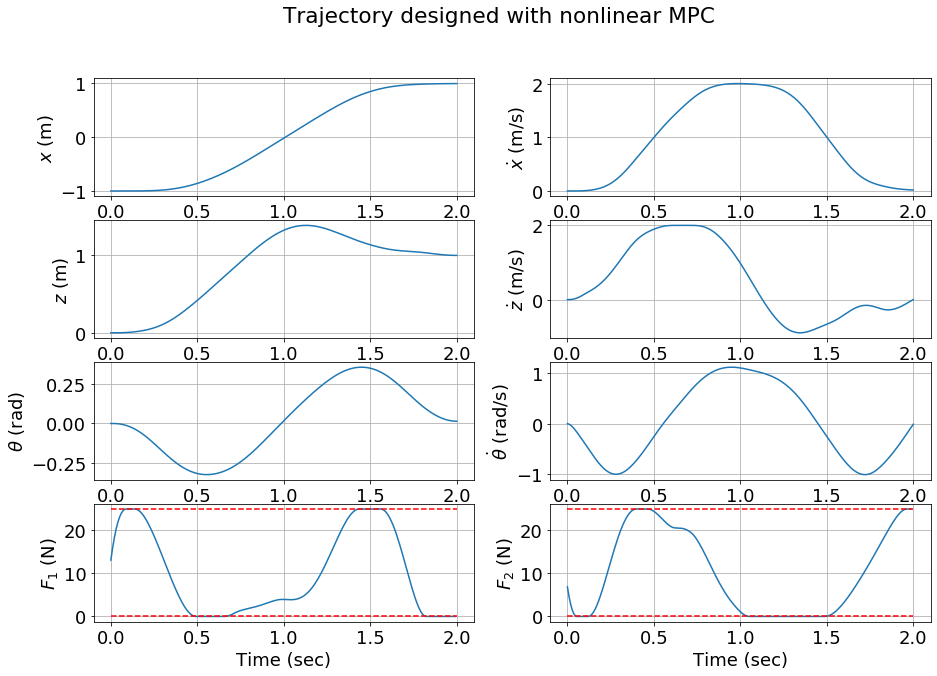

In [63]:
import matplotlib.pyplot as plt
t_eval = np.arange(0,201)*0.01
plt.figure(figsize=(15,10))
plt.suptitle('Trajectory designed with nonlinear MPC')
plt.subplot(4,2,1)
plt.plot(t_eval,mpc.data.prediction(('_x','xpos')).squeeze())
plt.ylabel('$x$ (m)')
plt.subplot(4,2,2)
plt.plot(t_eval,mpc.data.prediction(('_x','dxpos')).squeeze())
plt.ylabel('$\\dot{x}$ (m/s)')
plt.subplot(4,2,3)
plt.plot(t_eval,mpc.data.prediction(('_x','zpos')).squeeze())
plt.ylabel('$z$ (m)')
plt.subplot(4,2,4)
plt.plot(t_eval,mpc.data.prediction(('_x','dzpos')).squeeze())
plt.ylabel('$\\dot{z}$ (m/s)')
plt.subplot(4,2,5)
plt.plot(t_eval,mpc.data.prediction(('_x','theta')).squeeze())
plt.ylabel('$\\theta$ (rad)')
plt.subplot(4,2,6)
plt.plot(t_eval,mpc.data.prediction(('_x','dtheta')).squeeze())
plt.ylabel('$\\dot{\\theta}$ (rad/s)')
plt.subplot(4,2,7)
plt.plot(t_eval[:-1],mpc.data.prediction(('_u','force')).squeeze()[0,:])
plt.plot([0, 2.], [umax[0], umax[0]], '--r')
plt.plot([0, 2.], [umin[0], umin[0]], '--r')
plt.ylabel('$F_1$ (N)')
plt.xlabel('Time (sec)')
plt.subplot(4,2,8)
plt.plot(t_eval[:-1],mpc.data.prediction(('_u','force')).squeeze()[1,:])
plt.plot([0, 2.], [umax[0], umax[0]], '--r')
plt.plot([0, 2.], [umin[0], umin[0]], '--r')
plt.ylabel('$F_2$ (N)')
plt.xlabel('Time (sec)')

plt.show()

#### Closed-loop simulation

In [37]:
%%capture
for k in range(200):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

#### Visualize the results

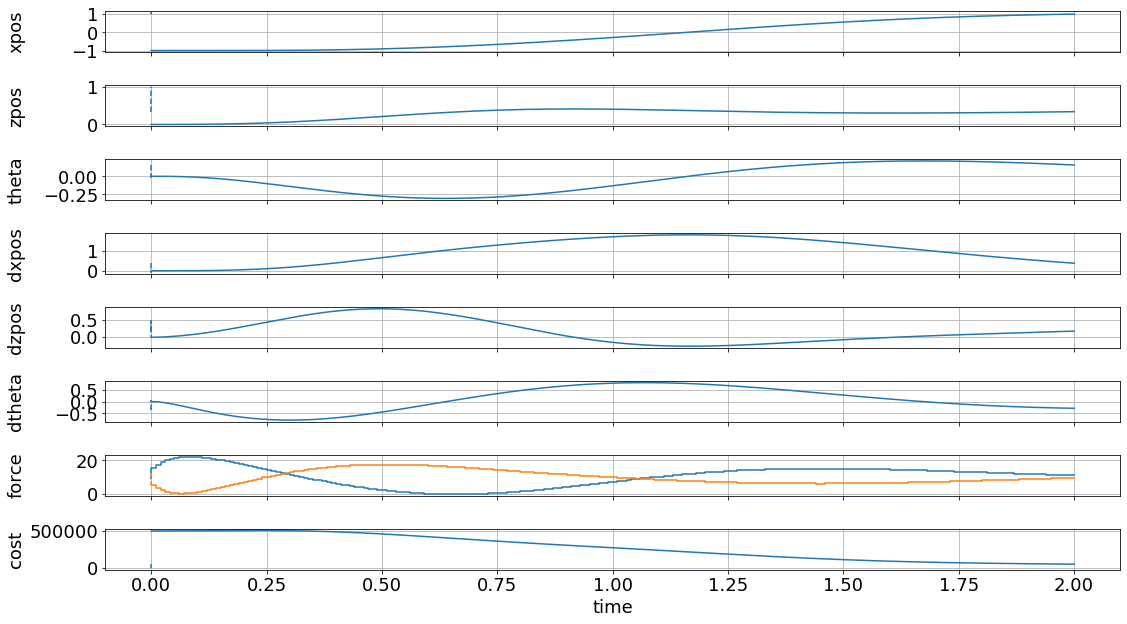

In [38]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
plt.show()